# Airsoft Event Detection Algorithms

This notebook contains advanced algorithms for automatically detecting spawn and death events from airsoft telemetry data using movement pattern analysis and machine learning techniques.

In [1]:
# Import Required Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Utility Functions

### Distance and Movement Calculations

In [2]:
def calculate_distance(lat1, lon1, lat2, lon2):
    """Calculate distance between two GPS points in meters"""
    return geodesic((lat1, lon1), (lat2, lon2)).meters

def calculate_bearing(lat1, lon1, lat2, lon2):
    """Calculate bearing from point 1 to point 2 in degrees"""
    import math
    
    lat1_rad = math.radians(lat1)
    lat2_rad = math.radians(lat2)
    dlon_rad = math.radians(lon2 - lon1)
    
    y = math.sin(dlon_rad) * math.cos(lat2_rad)
    x = math.cos(lat1_rad) * math.sin(lat2_rad) - math.sin(lat1_rad) * math.cos(lat2_rad) * math.cos(dlon_rad)
    
    bearing_rad = math.atan2(y, x)
    bearing_deg = math.degrees(bearing_rad)
    
    return (bearing_deg + 360) % 360  # Normalize to 0-360 degrees

def angle_difference(angle1, angle2):
    """Calculate the smallest difference between two angles in degrees"""
    diff = abs(angle1 - angle2)
    return min(diff, 360 - diff)

def calculate_speed(df):
    """Calculate speed in m/s between consecutive points"""
    speeds = [0]  # First point has no speed
    
    for i in range(1, len(df)):
        prev_row = df.iloc[i-1]
        curr_row = df.iloc[i]
        
        distance = calculate_distance(
            prev_row['Latitude'], prev_row['Longitude'],
            curr_row['Latitude'], curr_row['Longitude']
        )
        
        time_diff = (pd.to_datetime(curr_row['Date Time']) - pd.to_datetime(prev_row['Date Time'])).total_seconds()
        
        if time_diff > 0:
            speed = distance / time_diff
        else:
            speed = 0
            
        speeds.append(speed)
    
    return speeds

## Improved Spawn Detection Algorithm

### Algorithm with Hysteresis and Validation

In [3]:
def improved_spawn_detection_with_start(df, spawn_lat, spawn_lon, spawn_radius=25, exit_radius=35):
    """
    Improved spawn detection that includes START events as the first spawn.
    
    Args:
        df: DataFrame with telemetry data
        spawn_lat, spawn_lon: Spawn point coordinates
        spawn_radius: Radius to consider as spawn area (meters)
        exit_radius: Hysteresis radius for leaving spawn (meters)
    
    Returns:
        List of spawn events with confidence scores
    """
    
    print("=== IMPROVED SPAWN DETECTION (INCLUDING START) ===")
    
    # Calculate distance to spawn point
    df = df.copy()
    df['distance_to_spawn'] = df.apply(
        lambda row: calculate_distance(row['Latitude'], row['Longitude'], spawn_lat, spawn_lon), 
        axis=1
    )
    
    # Convert time column for easier handling
    df['datetime'] = pd.to_datetime(df['Date Time'])
    
    spawn_events = []
    
    # 1. Add START event as the first spawn
    start_events = df[df['Event Type'] == 'START']
    if len(start_events) > 0:
        start_event = start_events.iloc[0]
        spawn_events.append({
            'index': start_event.name,
            'time': start_event['datetime'],
            'lat': start_event['Latitude'],
            'lon': start_event['Longitude'],
            'distance_to_spawn': start_event['distance_to_spawn'],
            'event_type': 'START',
            'confidence': 1.0  # START events are definitive spawns
        })
        print(f"Added START event as first spawn: {start_event['datetime']}")
    
    # 2. Detect respawns using hysteresis
    outside_spawn = False
    exit_time = None
    exit_location = None
    
    for idx, row in df.iterrows():
        distance = row['distance_to_spawn']
        
        if not outside_spawn and distance > exit_radius:
            # Player left spawn area
            outside_spawn = True
            exit_time = row['datetime']
            exit_location = (row['Latitude'], row['Longitude'])
        
        elif outside_spawn and distance <= spawn_radius:
            # Player returned to spawn area (respawn detected)
            if exit_time is not None:
                time_outside = (row['datetime'] - exit_time).total_seconds()
                distance_traveled = calculate_distance(
                    exit_location[0], exit_location[1], 
                    row['Latitude'], row['Longitude']
                ) if exit_location else 0
                
                # Only count as respawn if they were outside for reasonable time
                if time_outside >= 30:  # At least 30 seconds outside
                    spawn_events.append({
                        'index': idx,
                        'time': row['datetime'],
                        'lat': row['Latitude'],
                        'lon': row['Longitude'],
                        'distance_to_spawn': distance,
                        'time_outside': time_outside,
                        'distance_traveled': distance_traveled,
                        'exit_location': exit_location,
                        'event_type': 'RESPAWN',
                        'confidence': min(0.8 + (time_outside / 300), 1.0)  # Higher confidence for longer time outside
                    })
            
            # Reset for next cycle
            outside_spawn = False
            exit_time = None
            exit_location = None
    
    print(f"Total spawn events detected: {len(spawn_events)}")
    
    # Sort by time
    spawn_events.sort(key=lambda x: x['time'])
    
    # Print results
    print("\nDetected Spawns:")
    for i, spawn in enumerate(spawn_events):
        event_type = spawn['event_type']
        if event_type == 'START':
            print(f"  {i+1}. {spawn['time']} - {event_type} (confidence: {spawn['confidence']:.2f})")
        else:
            print(f"  {i+1}. {spawn['time']} - {event_type} "
                  f"(confidence: {spawn['confidence']:.2f}, "
                  f"outside: {spawn['time_outside']:.0f}s)")
    
    return spawn_events

## Advanced Death Detection Algorithm

### Algorithm with Backtracking and Movement Analysis

In [4]:
def cluster_and_filter_deaths(death_candidates, distance_threshold=20, time_threshold=60, confidence_threshold=0.8):
    """
    Cluster nearby death candidates and filter by confidence threshold.
    
    Args:
        death_candidates: List of death candidate dictionaries
        distance_threshold: Maximum distance in meters to cluster deaths
        time_threshold: Maximum time in seconds to cluster deaths  
        confidence_threshold: Minimum confidence to keep a death
    
    Returns:
        List of filtered and clustered death events
    """
    
    if not death_candidates:
        return []
    
    # First filter by confidence
    high_confidence_deaths = [d for d in death_candidates if d['confidence'] >= confidence_threshold]
    
    if not high_confidence_deaths:
        return []
    
    # Sort by time for clustering
    high_confidence_deaths.sort(key=lambda x: x['death_time'])
    
    clustered_deaths = []
    
    for candidate in high_confidence_deaths:
        # Check if this candidate should be merged with any existing clustered death
        merged = False
        
        for existing in clustered_deaths:
            # Calculate distance between candidates
            distance = calculate_distance(
                candidate['death_lat'], candidate['death_lon'],
                existing['death_lat'], existing['death_lon']
            )
            
            # Calculate time difference
            time_diff = abs((candidate['death_time'] - existing['death_time']).total_seconds())
            
            # If close in space and time, merge by keeping the higher confidence one
            if distance <= distance_threshold and time_diff <= time_threshold:
                if candidate['confidence'] > existing['confidence']:
                    # Replace existing with this higher confidence candidate
                    existing.update(candidate)
                merged = True
                break
        
        # If not merged with any existing death, add as new
        if not merged:
            clustered_deaths.append(candidate.copy())
    
    return clustered_deaths

In [5]:
def improved_death_detection_with_backtracking(df, spawn_lat, spawn_lon, spawn_radius=25, 
                                               confidence_threshold=0.8, max_backtrack_time=300):
    """
    Improved death detection that handles delayed HIT button presses.
    Looks backward from detected movement anomalies to find the actual death location.
    
    Key improvements:
    1. Detects movement anomalies (sudden stops, direction changes toward spawn)
    2. Backtracks to find the most likely death location before the anomaly
    3. Handles cases where players press HIT while walking back to spawn
    
    Args:
        df: DataFrame with telemetry data
        spawn_lat, spawn_lon: Spawn point coordinates
        spawn_radius: Radius of spawn area (meters)
        confidence_threshold: Minimum confidence for death detection
        max_backtrack_time: Maximum time to look back for death (seconds)
    
    Returns:
        List of detected death events with confidence scores
    """
    
    print("=== IMPROVED DEATH DETECTION WITH BACKTRACKING ===")
    
    # Calculate movement metrics - use correct column names
    df = df.copy()
    df['time_diff'] = pd.to_datetime(df['Date Time']).diff().dt.total_seconds()
    df['lat_diff'] = df['Latitude'].diff()
    df['lon_diff'] = df['Longitude'].diff()
    
    # Calculate distance to spawn point
    df['distance_to_spawn'] = df.apply(
        lambda row: calculate_distance(row['Latitude'], row['Longitude'], spawn_lat, spawn_lon), 
        axis=1
    )
    
    # Calculate movement speed and direction
    df['speed'] = df.apply(lambda row: 
        calculate_distance(row['Latitude'] - row['lat_diff'], row['Longitude'] - row['lon_diff'], 
                          row['Latitude'], row['Longitude']) / max(row['time_diff'], 1) 
        if pd.notna(row['time_diff']) and row['time_diff'] > 0 else 0, axis=1)
    
    # Calculate direction toward spawn
    df['direction_to_spawn'] = df.apply(lambda row: 
        calculate_bearing(row['Latitude'], row['Longitude'], spawn_lat, spawn_lon), axis=1)
    
    # Calculate actual movement direction
    df['movement_direction'] = df.apply(lambda row: 
        calculate_bearing(row['Latitude'] - row['lat_diff'], row['Longitude'] - row['lon_diff'],
                         row['Latitude'], row['Longitude']) 
        if pd.notna(row['lat_diff']) and pd.notna(row['lon_diff']) else None, axis=1)
    
    # Convert time column for easier handling
    df['datetime'] = pd.to_datetime(df['Date Time'])
    
    # Detect movement anomalies that suggest death occurred
    anomaly_candidates = []
    
    for i in range(5, len(df) - 5):  # Need context before and after
        current = df.iloc[i]
        
        # Skip if too close to spawn (already dead/respawning)
        if current['distance_to_spawn'] < spawn_radius * 1.5:
            continue
        
        # Look at movement patterns around this point
        window_before = df.iloc[max(0, i-5):i]
        window_after = df.iloc[i:min(len(df), i+6)]
        
        # Calculate metrics for anomaly detection
        speed_before = window_before['speed'].mean() if len(window_before) > 0 else 0
        speed_after = window_after['speed'].mean() if len(window_after) > 0 else 0
        
        # Check for sudden movement changes
        speed_reduction = (speed_before - speed_after) / max(speed_before, 0.1)
        
        # Check direction consistency toward spawn
        directions_after = window_after['movement_direction'].dropna()
        spawn_direction = current['direction_to_spawn']
        
        direction_consistency = 0
        if len(directions_after) > 0 and pd.notna(spawn_direction):
            direction_diffs = [abs(angle_difference(d, spawn_direction)) for d in directions_after]
            direction_consistency = sum(1 for diff in direction_diffs if diff < 45) / len(direction_diffs)
        
        # Check if player is moving toward spawn after this point
        distance_trend = window_after['distance_to_spawn'].diff().mean() if len(window_after) > 1 else 0
        moving_toward_spawn = distance_trend < -1  # Moving closer to spawn
        
        # Anomaly scoring
        anomaly_score = 0
        
        # High speed reduction suggests sudden stop/death
        if speed_reduction > 0.5:
            anomaly_score += 0.4
        
        # Consistent movement toward spawn suggests death->respawn
        if direction_consistency > 0.6:
            anomaly_score += 0.3
        
        # Actually moving closer to spawn
        if moving_toward_spawn:
            anomaly_score += 0.2
        
        # Time gap might indicate manual event recording
        time_gaps = window_after['time_diff'].values
        if any(gap > 5 for gap in time_gaps if pd.notna(gap)):
            anomaly_score += 0.1
        
        if anomaly_score >= 0.6:  # Threshold for anomaly detection
            anomaly_candidates.append({
                'anomaly_index': i,
                'anomaly_time': current['datetime'],
                'anomaly_lat': current['Latitude'],
                'anomaly_lon': current['Longitude'],
                'anomaly_score': anomaly_score,
                'speed_reduction': speed_reduction,
                'direction_consistency': direction_consistency,
                'moving_toward_spawn': moving_toward_spawn
            })
    
    print(f"Found {len(anomaly_candidates)} movement anomalies")
    
    # For each anomaly, backtrack to find the likely death location
    death_candidates = []
    
    for anomaly in anomaly_candidates:
        anomaly_idx = anomaly['anomaly_index']
        anomaly_time = anomaly['anomaly_time']
        
        # Look backward up to max_backtrack_time seconds
        backtrack_start_time = anomaly_time - pd.Timedelta(seconds=max_backtrack_time)
        backtrack_window = df[(df['datetime'] >= backtrack_start_time) & (df['datetime'] <= anomaly_time)]
        
        if len(backtrack_window) < 3:
            continue
        
        # Find the best death candidate by analyzing movement patterns
        best_death_idx = None
        best_score = 0
        
        for i in range(len(backtrack_window) - 1):
            candidate_row = backtrack_window.iloc[i]
            next_row = backtrack_window.iloc[i + 1]
            
            # Skip if too close to spawn
            if candidate_row['distance_to_spawn'] < spawn_radius * 2:
                continue
            
            # Score this location as a potential death point
            death_score = 0
            
            # Prefer locations farther from spawn (died in combat zone)
            distance_factor = min(candidate_row['distance_to_spawn'] / 100, 1.0)  # Normalize to 100m
            death_score += distance_factor * 0.3
            
            # Look for sudden speed changes after this point
            remaining_window = backtrack_window.iloc[i:]
            if len(remaining_window) > 1:
                speed_changes = remaining_window['speed'].diff().abs().mean()
                if speed_changes > 2:  # Significant speed variation
                    death_score += 0.2
            
            # Prefer locations where movement toward spawn begins
            if pd.notna(next_row['movement_direction']) and pd.notna(candidate_row['direction_to_spawn']):
                direction_diff = abs(angle_difference(next_row['movement_direction'], 
                                                     candidate_row['direction_to_spawn']))
                if direction_diff < 30:  # Started moving toward spawn
                    death_score += 0.3
            
            # Temporal factor - prefer earlier in the backtrack window
            time_factor = (anomaly_time - candidate_row['datetime']).total_seconds() / max_backtrack_time
            death_score += time_factor * 0.2
            
            if death_score > best_score:
                best_score = death_score
                best_death_idx = i
        
        # Create death candidate if we found a good location
        if best_death_idx is not None:
            death_row = backtrack_window.iloc[best_death_idx]
            
            # Find the next spawn after this death
            spawn_after = df[(df['datetime'] > death_row['datetime']) & 
                            (df['distance_to_spawn'] <= spawn_radius)].head(1)
            
            if len(spawn_after) > 0:
                spawn_time = spawn_after.iloc[0]['datetime']
                time_to_spawn = (spawn_time - death_row['datetime']).total_seconds()
                
                # Calculate confidence based on multiple factors
                confidence = anomaly['anomaly_score'] * 0.4 + best_score * 0.6
                confidence = min(confidence, 1.0)
                
                death_candidates.append({
                    'death_time': death_row['datetime'],
                    'death_lat': death_row['Latitude'],
                    'death_lon': death_row['Longitude'],
                    'spawn_time': spawn_time,
                    'time_to_spawn': time_to_spawn,
                    'confidence': confidence,
                    'anomaly_time': anomaly_time,
                    'backtrack_seconds': (anomaly_time - death_row['datetime']).total_seconds(),
                    'distance_to_spawn': death_row['distance_to_spawn'],
                    'anomaly_score': anomaly['anomaly_score'],
                    'death_score': best_score
                })
    
    print(f"Found {len(death_candidates)} potential death locations through backtracking")
    
    # Remove duplicates and cluster nearby deaths
    final_deaths = cluster_and_filter_deaths(death_candidates, 
                                           distance_threshold=30,  # 30m clustering 
                                           time_threshold=120,     # 2 min clustering
                                           confidence_threshold=confidence_threshold)
    
    print(f"After clustering and filtering: {len(final_deaths)} final deaths")
    
    # Sort by time
    final_deaths.sort(key=lambda x: x['death_time'])
    
    # Print results
    print("\nDetected Deaths (with backtracking):")
    for i, death in enumerate(final_deaths):
        print(f"  {i+1}. {death['death_time']} - Confidence: {death['confidence']:.2f} "
              f"- Backtracked: {death['backtrack_seconds']:.0f}s "
              f"- Distance to spawn: {death['distance_to_spawn']:.1f}m")
    
    return final_deaths

## Algorithm Testing and Validation

### Load Data and Test Algorithms

In [6]:
# Load and prepare test data
sample_path = './data/sample-1.csv'
df = pd.read_csv(sample_path)

# Clean and prepare data
df = df.iloc[1:].copy()
df.at[df.index[0], 'Event Type'] = 'START'

# Use the actual game start location as spawn point
spawn_lat, spawn_lon = df.iloc[0]['Latitude'], df.iloc[0]['Longitude']
spawn_radius = 25  # meters

print(f"Using game start location as spawn point:")
print(f"  Latitude: {spawn_lat:.6f}")
print(f"  Longitude: {spawn_lon:.6f}")
print(f"  Spawn radius: {spawn_radius}m")
print(f"  Start time: {df.iloc[0]['Date Time']}")

# Add speed calculations
df['Speed_ms'] = calculate_speed(df)

Using game start location as spawn point:
  Latitude: 42.557137
  Longitude: -87.959649
  Spawn radius: 25m
  Start time: 2025-06-22 16:16:06.250


In [7]:
# Test improved spawn detection
print("\n" + "=" * 60)
improved_spawns = improved_spawn_detection_with_start(df, spawn_lat, spawn_lon)

print("\n" + "=" * 60)
# Test improved death detection with backtracking
improved_deaths = improved_death_detection_with_backtracking(df, spawn_lat, spawn_lon, confidence_threshold=0.6)


=== IMPROVED SPAWN DETECTION (INCLUDING START) ===
Added START event as first spawn: 2025-06-22 16:16:06.250000
Total spawn events detected: 5

Detected Spawns:
  1. 2025-06-22 16:16:06.250000 - START (confidence: 1.00)
  2. 2025-06-22 16:27:40.409000 - RESPAWN (confidence: 1.00, outside: 155s)
  3. 2025-06-22 16:34:49.408000 - RESPAWN (confidence: 1.00, outside: 385s)
  4. 2025-06-22 16:40:45.406000 - RESPAWN (confidence: 1.00, outside: 340s)
  5. 2025-06-22 16:45:06.414000 - RESPAWN (confidence: 1.00, outside: 245s)

=== IMPROVED DEATH DETECTION WITH BACKTRACKING ===
Found 9 movement anomalies
Found 9 potential death locations through backtracking
After clustering and filtering: 4 final deaths

Detected Deaths (with backtracking):
  1. 2025-06-22 16:26:51.408000 - Confidence: 0.70 - Backtracked: 294s - Distance to spawn: 68.9m
  2. 2025-06-22 16:31:47.405000 - Confidence: 0.76 - Backtracked: 300s - Distance to spawn: 108.1m
  3. 2025-06-22 16:33:50.396000 - Confidence: 0.76 - Backtr

## Algorithm Validation

### Compare Against Manual Events

In [8]:
def validate_improved_algorithms(df, improved_spawns, improved_deaths, spawn_lat, spawn_lon):
    """Validate improved algorithms against manual events"""
    
    # Get manual events
    manual_events = df[df['Event Type'].isin(['START', 'SPAWN', 'HIT', 'KILL'])].copy()
    manual_spawns = manual_events[manual_events['Event Type'].isin(['START', 'SPAWN'])]
    manual_hits = manual_events[manual_events['Event Type'] == 'HIT']
    
    print("=== IMPROVED SPAWN DETECTION VALIDATION ===")
    print(f"Manual spawn events (START + SPAWN): {len(manual_spawns)}")
    print(f"Improved algorithm spawns: {len(improved_spawns)}")
    
    # Check spawn matching
    matched_spawns = 0
    manual_spawn_times = [pd.to_datetime(row['Date Time']) for _, row in manual_spawns.iterrows()]
    
    for auto_spawn in improved_spawns:
        auto_time = auto_spawn['time']
        
        # Find closest manual spawn within 2 minutes
        min_time_diff = float('inf')
        for manual_time in manual_spawn_times:
            time_diff = abs((auto_time - manual_time).total_seconds())
            if time_diff < min_time_diff:
                min_time_diff = time_diff
        
        if min_time_diff <= 120:  # Within 2 minutes
            matched_spawns += 1
            print(f"  ✓ Matched: Auto {auto_time} (±{min_time_diff:.1f}s)")
        else:
            print(f"  ✗ Unmatched: Auto {auto_time}")
    
    # Spawn performance metrics
    spawn_precision = matched_spawns / len(improved_spawns) if len(improved_spawns) > 0 else 0
    spawn_recall = matched_spawns / len(manual_spawns) if len(manual_spawns) > 0 else 0
    spawn_f1 = 2 * (spawn_precision * spawn_recall) / (spawn_precision + spawn_recall) if (spawn_precision + spawn_recall) > 0 else 0
    
    print(f"\nSpawn Detection Performance:")
    print(f"  - Precision: {spawn_precision:.2%}")
    print(f"  - Recall: {spawn_recall:.2%}")
    print(f"  - F1 Score: {spawn_f1:.2%}")
    
    print("\n=== IMPROVED DEATH DETECTION VALIDATION ===")
    print(f"Manual hit events: {len(manual_hits)}")
    print(f"Improved algorithm deaths: {len(improved_deaths)}")
    
    if len(improved_deaths) > 0:
        # Check death matching
        matched_deaths = 0
        manual_hit_times = [pd.to_datetime(row['Date Time']) for _, row in manual_hits.iterrows()]
        
        for auto_death in improved_deaths:
            auto_time = auto_death['death_time']
            
            # Find closest manual hit within 3 minutes
            min_time_diff = float('inf')
            for manual_time in manual_hit_times:
                time_diff = abs((auto_time - manual_time).total_seconds())
                if time_diff < min_time_diff:
                    min_time_diff = time_diff
            
            if min_time_diff <= 180:  # Within 3 minutes
                matched_deaths += 1
                print(f"  ✓ Matched: Auto {auto_time} (±{min_time_diff:.1f}s, conf: {auto_death['confidence']:.2f})")
            else:
                print(f"  ✗ Unmatched: Auto {auto_time} (conf: {auto_death['confidence']:.2f})")
        
        # Death performance metrics
        death_precision = matched_deaths / len(improved_deaths) if len(improved_deaths) > 0 else 0
        death_recall = matched_deaths / len(manual_hits) if len(manual_hits) > 0 else 0
        death_f1 = 2 * (death_precision * death_recall) / (death_precision + death_recall) if (death_precision + death_recall) > 0 else 0
        
        print(f"\nDeath Detection Performance:")
        print(f"  - Precision: {death_precision:.2%}")
        print(f"  - Recall: {death_recall:.2%}")
        print(f"  - F1 Score: {death_f1:.2%}")
    else:
        print("No deaths detected - algorithm too conservative")
        death_precision = death_recall = death_f1 = 0
    
    print("\n=== OVERALL IMPROVED ALGORITHM PERFORMANCE ===")
    total_auto = len(improved_spawns) + len(improved_deaths)
    total_manual = len(manual_spawns) + len(manual_hits)
    total_matched = matched_spawns + (matched_deaths if len(improved_deaths) > 0 else 0)
    
    overall_precision = total_matched / total_auto if total_auto > 0 else 0
    overall_recall = total_matched / total_manual if total_manual > 0 else 0
    overall_f1 = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0
    
    print(f"  - Overall Precision: {overall_precision:.2%}")
    print(f"  - Overall Recall: {overall_recall:.2%}")
    print(f"  - Overall F1 Score: {overall_f1:.2%}")
    print(f"  - Detection Rate: {total_auto}/{total_manual} events")
    
    return {
        'spawn_precision': spawn_precision,
        'spawn_recall': spawn_recall,
        'spawn_f1': spawn_f1,
        'death_precision': death_precision,
        'death_recall': death_recall,  
        'death_f1': death_f1,
        'overall_precision': overall_precision,
        'overall_recall': overall_recall,
        'overall_f1': overall_f1
    }

# Run validation
results = validate_improved_algorithms(df, improved_spawns, improved_deaths, spawn_lat, spawn_lon)

=== IMPROVED SPAWN DETECTION VALIDATION ===
Manual spawn events (START + SPAWN): 6
Improved algorithm spawns: 5
  ✓ Matched: Auto 2025-06-22 16:16:06.250000 (±0.0s)
  ✓ Matched: Auto 2025-06-22 16:27:40.409000 (±12.4s)
  ✓ Matched: Auto 2025-06-22 16:34:49.408000 (±44.2s)
  ✓ Matched: Auto 2025-06-22 16:40:45.406000 (±8.1s)
  ✓ Matched: Auto 2025-06-22 16:45:06.414000 (±2.1s)

Spawn Detection Performance:
  - Precision: 100.00%
  - Recall: 83.33%
  - F1 Score: 90.91%

=== IMPROVED DEATH DETECTION VALIDATION ===
Manual hit events: 4
Improved algorithm deaths: 4
  ✓ Matched: Auto 2025-06-22 16:26:51.408000 (±6.1s, conf: 0.70)
  ✓ Matched: Auto 2025-06-22 16:31:47.405000 (±167.8s, conf: 0.76)
  ✓ Matched: Auto 2025-06-22 16:33:50.396000 (±44.8s, conf: 0.76)
  ✓ Matched: Auto 2025-06-22 16:44:23.208000 (±2.9s, conf: 0.66)

Death Detection Performance:
  - Precision: 100.00%
  - Recall: 100.00%
  - F1 Score: 100.00%

=== OVERALL IMPROVED ALGORITHM PERFORMANCE ===
  - Overall Precision: 100.

## Visualization

### Event Detection Results

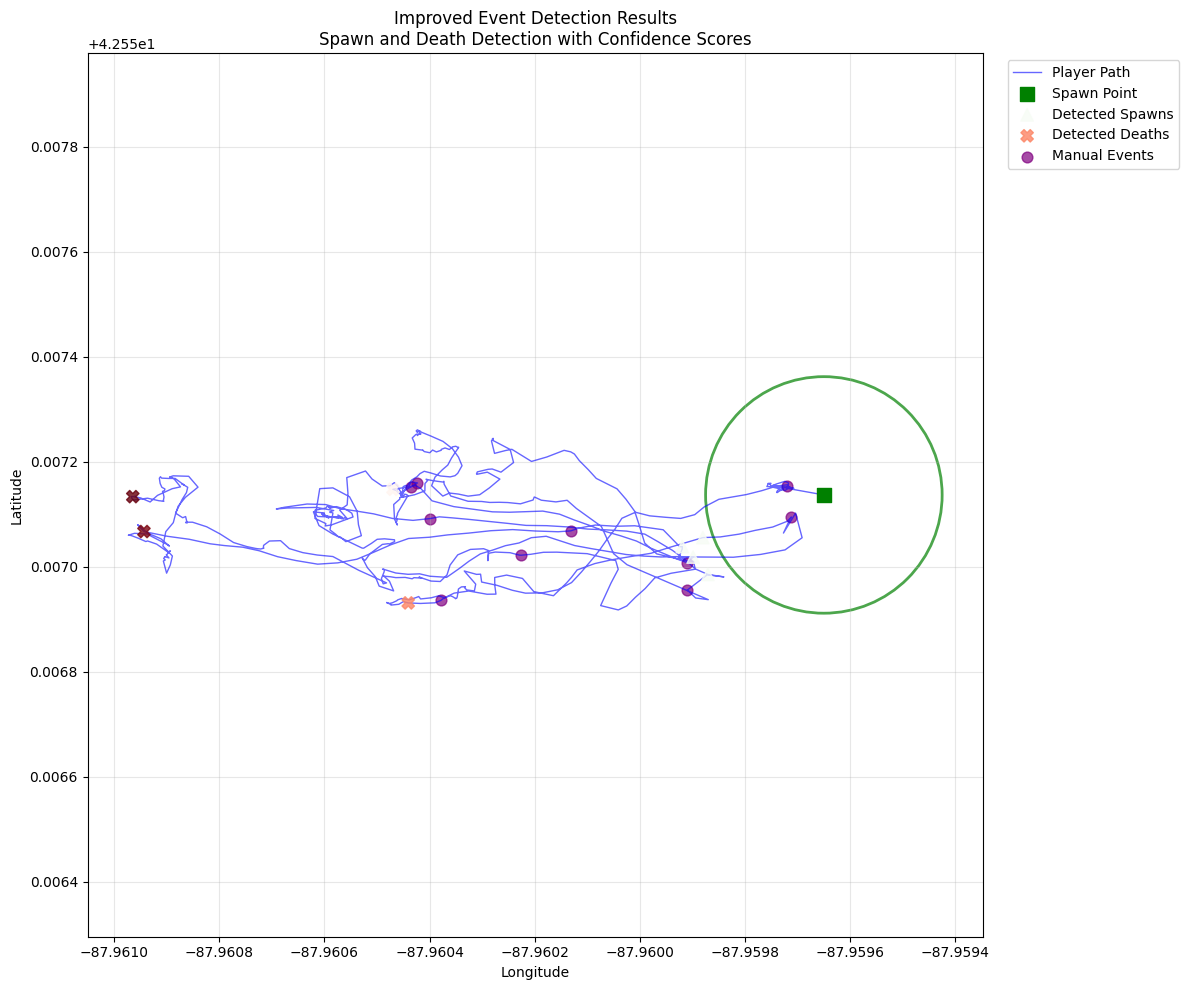


Visualization Summary:
- Player path: 991 GPS points
- Detected spawns: 5
- Detected deaths: 4
- Manual events: 11
- Spawn area radius: 25m


In [17]:
# Create visualization of results
plt.figure(figsize=(12, 10))

# Plot player path
plt.plot(df['Longitude'], df['Latitude'], 'b-', alpha=0.6, linewidth=1, label='Player Path')

# Plot spawn area
spawn_circle = plt.Circle((spawn_lon, spawn_lat), spawn_radius/111000, 
                         color='green', fill=False, linewidth=2, alpha=0.7)
plt.gca().add_patch(spawn_circle)

# Plot spawn point
plt.scatter([spawn_lon], [spawn_lat], c='green', s=100, marker='s', 
           label='Spawn Point', zorder=5)

# Plot detected spawns
if improved_spawns:
    spawn_lons = [s['lon'] for s in improved_spawns]
    spawn_lats = [s['lat'] for s in improved_spawns]
    spawn_confidences = [s['confidence'] for s in improved_spawns]
    
    scatter_spawns = plt.scatter(spawn_lons, spawn_lats, c=spawn_confidences, 
                                cmap='Greens', s=80, marker='^', 
                                label='Detected Spawns', alpha=0.8, zorder=4)

# Plot detected deaths
if improved_deaths:
    death_lons = [d['death_lon'] for d in improved_deaths]
    death_lats = [d['death_lat'] for d in improved_deaths] 
    death_confs = [d['confidence'] for d in improved_deaths]
    
    scatter_deaths = plt.scatter(death_lons, death_lats, c=death_confs,
                                cmap='Reds', s=80, marker='X',
                                label='Detected Deaths', alpha=0.8, zorder=4)

# Plot manual events for comparison
manual_events = df[df['Event Type'].isin(['START', 'SPAWN', 'HIT', 'KILL'])]
for i, (_, event) in enumerate(manual_events.iterrows()):
    plt.scatter(event['Longitude'], event['Latitude'], 
               c='purple', s=60, marker='o', alpha=0.7,
               label='Manual Events' if i == 0 else "")

# Configure plot appearance
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Improved Event Detection Results\nSpawn and Death Detection with Confidence Scores')
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.grid(True, alpha=0.3)

# Set equal aspect ratio to prevent stretching
plt.axis('equal')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nVisualization Summary:")
print(f"- Player path: {len(df)} GPS points")
print(f"- Detected spawns: {len(improved_spawns) if improved_spawns else 0}")
print(f"- Detected deaths: {len(improved_deaths) if improved_deaths else 0}")
print(f"- Manual events: {len(manual_events)}")
print(f"- Spawn area radius: {spawn_radius}m")

## Flutter Implementation Notes

### Key Design Decisions

**Spawn Point Definition**: The spawn point is defined as the **game start location** - where the user pressed "start" to begin tracking.

### Algorithm Parameters for Production

**Spawn Detection**:
- `spawn_radius`: 25 meters
- `exit_radius`: 35 meters (hysteresis)
- `min_time_outside`: 30 seconds

**Death Detection**:
- `confidence_threshold`: 0.6-0.8
- `max_backtrack_time`: 300 seconds (5 minutes)
- `distance_threshold`: 30 meters (clustering)
- `time_threshold`: 120 seconds (clustering)

### Implementation Tips

1. **Real-time Processing**: Algorithms can run in background with periodic updates
2. **Battery Optimization**: Use movement-triggered analysis rather than continuous processing
3. **User Feedback**: Allow manual correction of detected events
4. **Confidence Scores**: Show confidence levels to users for transparency
5. **Parameter Tuning**: Allow advanced users to adjust detection sensitivity